Library Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

0it [00:00, ?it/s]

9920512it [00:01, 9396426.97it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135373.69it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2199272.01it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 52613.69it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


1. Splitting The Training Set

In [2]:
validation_size = int(0.05*len(train_data))
training_size = int(0.95*len(train_data))

train_dataset, validation_dataset = torch.utils.data.random_split(train_data, [training_size, validation_size])

print(len(validation_dataset))

3000


Load Data

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)

## 2. Encoder & Decoder in Different Modules with bottleneck value passed in

In [0]:
class Encoder(nn.Module):

   def __init__(self,bottleneck):
     super().__init__()

     self.conv1 = nn.Conv2d(1,16,3,padding=1)
     self.conv2 = nn.Conv2d(16,bottleneck,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)

   def forward(self,x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        return x

class Decoder(nn.Module):

   def __init__(self,bottleneck):
     super().__init__()

     ## decoder layers ##
     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.t_conv1 = nn.ConvTranspose2d(bottleneck, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     
       

   def forward(self,x):
     ## decode ##
     # add transpose conv layers, with relu activation function
     x = F.relu(self.t_conv1(x))
     # output layer (with sigmoid for scaling from 0 to 1)
     x = F.sigmoid(self.t_conv2(x))
            
     return x

class Concatenator(nn.Module):

  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    #encode
    x = self.encoder(x)
    y = self.decoder(x)

    return y



Training function              

In [0]:
def train_model_ex1(model, optimizer, criterion, train_loader,validation_loader, epochs):

  train_losses, val_losses = [], []

  for e in range(1, epochs+1):
        train_loss = 0.0  # monitor training loss
        validation_loss = 0.0 

        
        ###################
        # train the model #
        ###################
        model.train()

        for data in train_loader:
            # we are just intrested in just images
            # no need to flatten images
            images, labels = data                        

            # clear the gradients
            optimizer.zero_grad()     

            # forward pass: compute predicted outputs 
            outputs = model(images)    

            # calculate the loss             
            loss = criterion(outputs, images)

            # backward pass     
            loss.backward()  

            # perform optimization step                       
            optimizer.step()           

            # update running training loss             
            train_loss += loss.item()*images.size(0)

        for data in validation_loader:
           model.eval()
           images, _ = data                        # we are just intrested in just images
           outputs = model(images)                 # forward pass: compute predicted outputs 
           loss = criterion(outputs, images)       # calculate the loss
           validation_loss += loss.item()*images.size(0)# update running training loss
        
        train_loss = train_loss/len(train_loader)

        print('Epoch: {}'.format(e),
              '\tTraining Loss: {:.4f}'.format(train_loss))
        validation_loss = validation_loss/len(validation_loader)
        print('Epoch: {}'.format(e),
                  '\tValidation Loss: {:.4f}'.format(validation_loss))
        train_losses.append(train_loss)
        val_losses.append(validation_loss)    

  return train_losses, val_losses

## 3. pass values to training & plot

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.6375
Epoch: 1 	Validation Loss: 0.3772
Epoch: 2 	Training Loss: 0.3502
Epoch: 2 	Validation Loss: 0.3319
Epoch: 3 	Training Loss: 0.3176
Epoch: 3 	Validation Loss: 0.3074


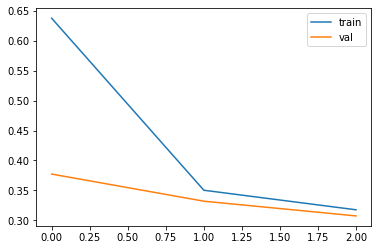

In [16]:
enc  =Encoder(3)
dec = Decoder(3)
model = Concatenator(enc,dec)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()    # is this correct? accroding to 3.


train_losses, val_losses = train_model_ex1(model, optimizer,criterion,train_loader,validation_loader,3)


import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()

plot test and val loss           //have not done for different bottlenecks

# 4. Test Loss  & val loss         

In [17]:
test_loss=0.0
val_loss = 0.0

for data in test_loader:
  images, _ = data                        # we are just intrested in just images
  # no need to flatten images
 # optimizer.zero_grad()                   # clear the gradients
  outputs = model(images)                 # forward pass: compute predicted outputs 
  loss = criterion(outputs, images)       # calculate the loss
  test_loss += loss.item()*images.size(0)

for data in validation_loader:
  images, _ = data                        # we are just intrested in just images
 # optimizer.zero_grad()                   # clear the gradients
  outputs = model(images)                 # forward pass: compute predicted outputs 
  loss = criterion(outputs, images)       # calculate the loss
  val_loss += loss.item()*images.size(0)
        
test_loss = test_loss/len(test_loader)
val_loss = val_loss/len(validation_loader)
print('test',test_loss)
print('val', val_loss)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('param', pytorch_total_params)




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test 0.30108537901192906
val 0.3073524560779333
param 868


# **5**.                              for model with some bottleneck

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


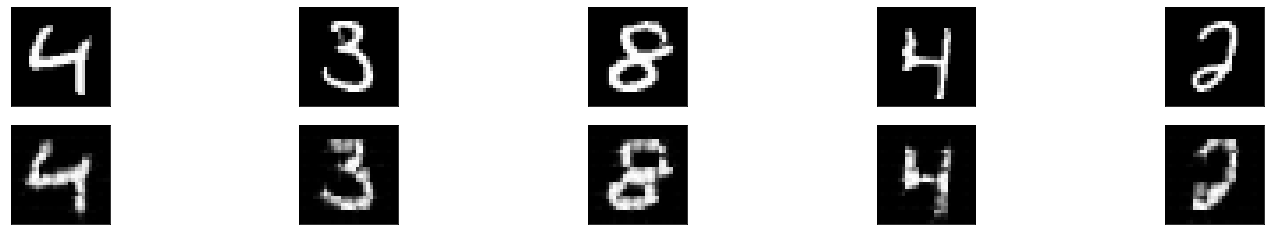

In [19]:
# Lets get batch of test images

import random
dataiter = iter(test_loader)

images, labels = dataiter.next()



output = model(images)                     # get sample outputs
images = images.numpy() 


                  # prep images for display
output = output.view(batch_size, 1, 28, 28)# resizing output
output = output.detach().numpy()           # use detach when it's an output that requires_grad




# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


6. Generate 5 new images by injecting random values as input to the decoder. Show them.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([5, 1, 28, 28])


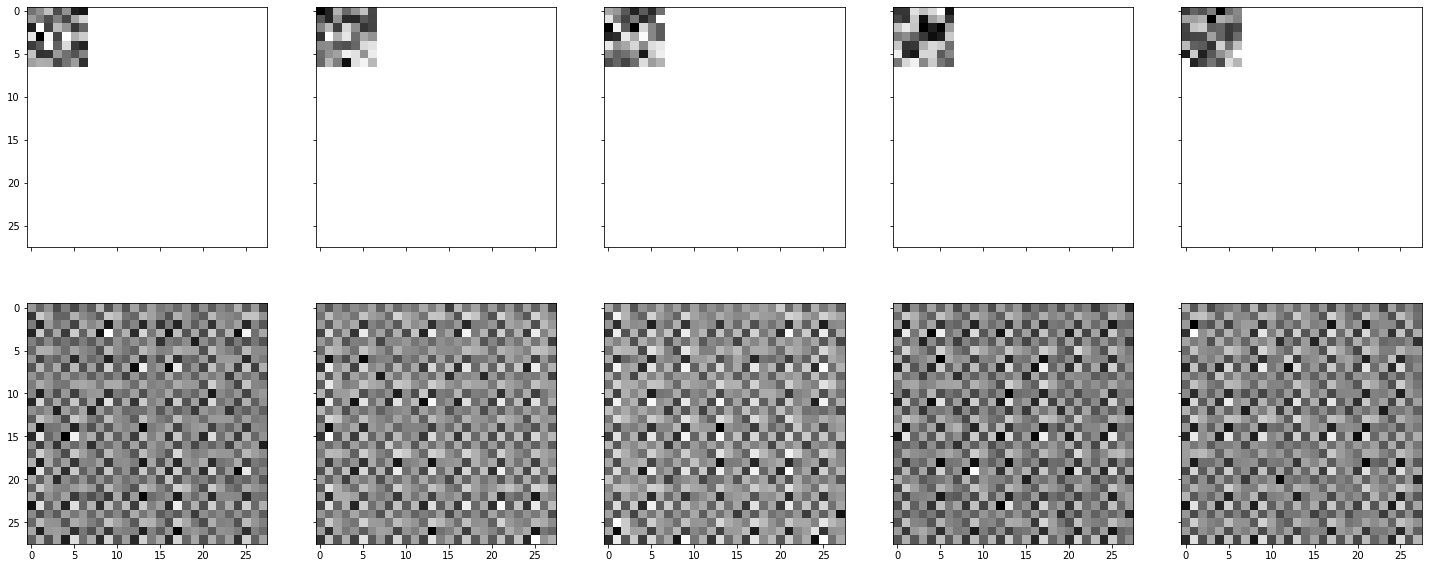

In [20]:
input = torch.rand(5,14,7,7)

new_dec = Decoder(14)
output = new_dec(input)
#print(np.squeeze(input[3].detach()).size())

#self.t_conv1 = nn.ConvTranspose2d(bottleneck, 16, 2, stride=2)
#self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
import cv2

from skimage import color
from skimage import io

input_new = input.view(5,14,7,7)
input_new = input.detach().numpy()
#output = output.view(5,3,28,28)
print(output.size())
output = output.detach().numpy()
out_new = output.reshape(5,28,28,1)
input_new = input_new.reshape(5,7,7,14)

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,10))
for i in range(5):
  #grayImage = your4Dimage(:,:,1,181)
  
  axes[0][i].imshow(color.rgb2gray(np.squeeze(input_new[i])),cmap = 'gray')
  axes[1][i].imshow(color.rgb2gray(np.squeeze(out_new[i])),cmap = 'gray')



fig.show()

## **Excercise** 2


# 1.Select subset of 100 images & labels

In [0]:
subset  = torch.utils.data.Subset(train_dataset, range(0, 100))
len(subset)
subset_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, num_workers=num_workers)



# 2. select one of the autoencoder

In [0]:
encoder = Encoder(3)


# 3. create the classification model

In [0]:
model_classifier =    nn.Sequential( nn.Linear(3*7*7,10),
                      nn.LogSoftmax(-1)
                      )

#model_2 = nn.Sequential(encoder,
 #                       nn.Flatten(),
  #                      nn.Linear(3*7*7,10),
    #                    nn.LogSoftmax(-1)
   #                     )

model_2 = nn.Sequential(encoder,
                        nn.Flatten(),
                        model_classifier)

# 4. Train the classifer

In [29]:
criterion = F.nll_loss

# Optimizer
#optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
optimizer = torch.optim.RMSprop(model_2.parameters(), lr=0.001)
train_losses, val_losses = [],[]
epochs = 10
model_2.train()
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    for data in subset_loader:
     
      images, labels = data                        # we are just intrested in just images & labels
      optimizer.zero_grad()                        # clear the gradients
      outputs = model_2(images)                    # forward pass: compute predicted outputs 
      loss = criterion(outputs, labels)           # calculate the loss
      loss.backward()                             # backward pass
      optimizer.step()                             # perform optimization step
      train_loss += loss.item()*images.size(0)     # update running training loss

      train_loss = train_loss/len(train_loader)
      print('Epoch: {}'.format(e),
              '\tTraining Loss: {:.4f}'.format(train_loss))
      train_losses.append(train_loss)
   #bottleneck = bottleneck +3
   #print (bottlneck)



Epoch: 1 	Training Loss: 0.0162
Epoch: 1 	Training Loss: 0.0163
Epoch: 1 	Training Loss: 0.0161
Epoch: 1 	Training Loss: 0.0162
Epoch: 1 	Training Loss: 0.0160
Epoch: 2 	Training Loss: 0.0157
Epoch: 2 	Training Loss: 0.0155
Epoch: 2 	Training Loss: 0.0153
Epoch: 2 	Training Loss: 0.0152
Epoch: 2 	Training Loss: 0.0145
Epoch: 3 	Training Loss: 0.0141
Epoch: 3 	Training Loss: 0.0133
Epoch: 3 	Training Loss: 0.0130
Epoch: 3 	Training Loss: 0.0125
Epoch: 3 	Training Loss: 0.0115
Epoch: 4 	Training Loss: 0.0116
Epoch: 4 	Training Loss: 0.0098
Epoch: 4 	Training Loss: 0.0100
Epoch: 4 	Training Loss: 0.0093
Epoch: 4 	Training Loss: 0.0090
Epoch: 5 	Training Loss: 0.0091
Epoch: 5 	Training Loss: 0.0068
Epoch: 5 	Training Loss: 0.0080
Epoch: 5 	Training Loss: 0.0071
Epoch: 5 	Training Loss: 0.0075
Epoch: 6 	Training Loss: 0.0075
Epoch: 6 	Training Loss: 0.0050
Epoch: 6 	Training Loss: 0.0067
Epoch: 6 	Training Loss: 0.0058
Epoch: 6 	Training Loss: 0.0064
Epoch: 7 	Training Loss: 0.0062
Epoch: 7

5. Fine tuning, using different learnig rates

In [30]:
criterion = F.nll_loss

# Optimizer
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.00000001)
optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=0.001)
#optimizer = torch.optim.RMSprop(model_2.parameters(), lr=0.001)

train_losses, val_losses = [],[]
epochs = 10
model_2.train()
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    for data in subset_loader:
     
      images, labels = data                        # we are just intrested in just images & labels
      optimizer.zero_grad()                        # clear the gradients
      optimizer1.zero_grad()                        # clear the gradients
      outputs = model_2(images)                    # forward pass: compute predicted outputs 
      loss = criterion(outputs, labels)           # calculate the loss
      loss.backward()                             # backward pass
      optimizer.step()                             # perform optimization step
      optimizer1.step()
      train_loss += loss.item()*images.size(0)     # update running training loss

      train_loss = train_loss/len(train_loader)
      print('Epoch: {}'.format(e),
              '\tTraining Loss: {:.4f}'.format(train_loss))
      train_losses.append(train_loss)
   


Epoch: 1 	Training Loss: 0.0033
Epoch: 1 	Training Loss: 0.0016
Epoch: 1 	Training Loss: 0.0035
Epoch: 1 	Training Loss: 0.0024
Epoch: 1 	Training Loss: 0.0035
Epoch: 2 	Training Loss: 0.0026
Epoch: 2 	Training Loss: 0.0014
Epoch: 2 	Training Loss: 0.0031
Epoch: 2 	Training Loss: 0.0023
Epoch: 2 	Training Loss: 0.0032
Epoch: 3 	Training Loss: 0.0024
Epoch: 3 	Training Loss: 0.0013
Epoch: 3 	Training Loss: 0.0030
Epoch: 3 	Training Loss: 0.0024
Epoch: 3 	Training Loss: 0.0028
Epoch: 4 	Training Loss: 0.0023
Epoch: 4 	Training Loss: 0.0012
Epoch: 4 	Training Loss: 0.0029
Epoch: 4 	Training Loss: 0.0023
Epoch: 4 	Training Loss: 0.0026
Epoch: 5 	Training Loss: 0.0022
Epoch: 5 	Training Loss: 0.0012
Epoch: 5 	Training Loss: 0.0027
Epoch: 5 	Training Loss: 0.0022
Epoch: 5 	Training Loss: 0.0026
Epoch: 6 	Training Loss: 0.0021
Epoch: 6 	Training Loss: 0.0011
Epoch: 6 	Training Loss: 0.0026
Epoch: 6 	Training Loss: 0.0020
Epoch: 6 	Training Loss: 0.0025
Epoch: 7 	Training Loss: 0.0020
Epoch: 7

## 6. Train the 100 samples from scratch


In [0]:
# without using encoder? or decoder

## 7. Show the accuracy of the four ??three?? models on the test set in a table